# Topic Modelling

Topic modeling uses a set of rules to extract topics from a text. It does this by identifying keywords in each text in a corpus (large collection of texts). Documents that are shorter, such as tweets, tend to fare better from rules-based approaches.

One of the most common ways to perform this task is via TF-IDF (term frequency-inverse document frequency). TF-IDF looks for a word's frequency in a single text, respective to that word's use across the corpus as a whole.

## Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
from string import punctuation
%matplotlib inline

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
#read dataset
df = pd.read_csv("newdata.csv")
df

,Unnamed: 0,Date,Tweet Text,Followers,Follows,Retweets,Favorites,Location,Airport_Twitter_Tag,Airport_IATA_Codes,Airport_Names
0,15421,4/7/2017 7:52,Update: Flt EI7RE departed back to Dublin at 0...,20959.0,240.0,0.0,0.0,"Belfast, Northern Ireland",@dublinairport,DUB,Dublin Airport
1,25645,12/3/2018 14:06,"@DublinAirport Ah lads come on, rally the troo...",1433.0,637.0,0.0,0.0,"Dublin, Ireland",@dublinairport,DUB,Dublin Airport
2,88734,12/24/2020 19:34:34,@DublinAirport https://t.co/8XPuZnW0P9,27616.0,868.0,0.0,0.0,"Halifax, NS",@dublinairport,DUB,Dublin Airport
3,181260,6/12/2020 0:33:26,@brskyrme @VirginAtlantic @HeathrowAirport @br...,51130.0,3181.0,0.0,0.0,San Francisco Int'l Airport,@heathrowairport,LHR,Heathrow Airport
4,262833,8/29/2020 0:36:32,@JetSetGOConnor @flykkylie @HeathrowAirport @S...,27451.0,452.0,0.0,2.0,"Washington, DC",@heathrowairport,LHR,Heathrow Airport
...,...,...,...,...,...,...,...,...,...,...,...
273183,868309,3/23/2021 21:21:43,@STN_Airport Thank you ??,11378.0,1057.0,0.0,0.0,"Manchester, England",@stn_airport,STN,London Stansted Airpor
273184,868344,3/24/2021 13:56:49,@STN_Airport Good morning stansted airport ????,95.0,958.0,0.0,0.0,NaN,@stn_airport,STN,London Stansted Airpor
273185,868346,3/24/2021 15:03:10,@STN_Airport OMG ...... if only you knew how m...,95.0,958.0,0.0,1.0,NaN,@stn_airport,STN,London Stansted Airpor
273186,868347,3/24/2021 15:06:29,@STN_Airport @KevinS22551757 Spain is in my bl...,95.0,958.0,0.0,1.0,NaN,@stn_airport,STN,London Stansted Airpor


##  Data Preprocessing 

In [3]:
def sent_to_words(sentences):
    for tweet in sentences:
        tweet = re.sub('\S*@\S*\s?', '', tweet)  # remove emails
        tweet = re.sub('\s+', ' ', tweet)  # remove newline chars
        tweet = re.sub("\'", "", tweet)  # remove single quotes
        # Remove HTML special entities (e.g. &amp;)
        tweet = re.sub(r'\&\w*;', '', tweet)
        #Convert @username to AT_USER
        tweet = re.sub('@[^\s]+','',tweet)
        # Remove tickers
        tweet = re.sub(r'\$\w*', '', tweet)
        # To lowercase
        tweet =  tweet.lower()
        # Remove hyperlinks
        tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
        # Remove hashtags
        tweet = re.sub(r'#\w*', '', tweet)
        # Remove Punctuation and split 's, 't, 've with a space for filter
        tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
        # Remove words with 2 or fewer letters
        tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
        # Remove whitespace (including new line characters)
        tweet = re.sub(r'\s\s+', ' ', tweet)
        # Remove single space remaining at the front of the tweet.
        tweet = tweet.lstrip(' ') 
        # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
        tweet = ''.join(c for c in tweet if c <= '\uFFFF')
        tweet = gensim.utils.simple_preprocess(str(tweet), deacc=True) 
        yield(tweet)  

# Convert to list
data = df["Tweet Text"].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[0])

['update', 'flt', 'ei', 're', 'departed', 'back', 'dublin', 'but', 'flt', 'ei', 'offloading', 'passengers', 'here', 'for', 'transfer', 'via', 'coach']


**Remove Stopwords and Lemmatize tokens**

In [4]:
stop_words = stopwords.words("english")

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [5]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

In [6]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(texts, allowed_postags=["NOUN"]):
    texts_out = []
    for text in texts:
        doc = nlp(" ".join(text))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

lemmatized_texts = lemmatization(data_words_nostops)
print(lemmatized_texts[0])

['update', 'passenger', 'coach']


## LDA model- Latent Dirichlet Allocation

In [7]:
#Create Dictionary
id2word = corpora.Dictionary(lemmatized_texts)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in lemmatized_texts]

In [8]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha = 'symmetric',
                                           per_word_topics=True)

In [9]:
print(lda_model.print_topics())

[(0, '0.082*"thank" + 0.044*"people" + 0.042*"parking" + 0.032*"car" + 0.024*"service" + 0.022*"park" + 0.020*"airport" + 0.019*"customer" + 0.017*"website" + 0.016*"passenger"'), (1, '0.074*"time" + 0.041*"security" + 0.022*"luggage" + 0.018*"arrival" + 0.016*"gate" + 0.016*"control" + 0.016*"passport" + 0.014*"airport" + 0.013*"letter" + 0.013*"queue"'), (2, '0.115*"flight" + 0.051*"plane" + 0.049*"hour" + 0.036*"family" + 0.025*"bag" + 0.022*"baggage" + 0.021*"birthday" + 0.021*"minute" + 0.017*"test" + 0.017*"travel"'), (3, '0.048*"year" + 0.041*"day" + 0.041*"morning" + 0.033*"airport" + 0.033*"love" + 0.032*"home" + 0.031*"staff" + 0.030*"today" + 0.027*"week" + 0.018*"guy"')]


## Topic Coherence 

In [10]:
lda_coherence_model = CoherenceModel(model= lda_model, texts = lemmatized_texts, dictionary = id2word,
                                    coherence='c_v')
coherence_lda = lda_coherence_model.get_coherence()

print("Coherence Score:", coherence_lda)

Coherence Score: 0.38435156845771223


## Improve topic coherence

In [11]:
def opt_coherence(dictionary, corpus, texts, limit, start=1, step=1):
    
    coherence_values=[]
    model_list = []
    for topics in range(start,limit,step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics = topics, random_state=100,
                                               chunksize=1000, passes = 10, per_word_topics=True, id2word=id2word, alpha = 'symmetric')
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=lemmatized_texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

model_list, coherence_values = opt_coherence(dictionary = id2word, corpus=corpus, texts =lemmatized_texts, limit=11,start=1,step=1)

<function matplotlib.pyplot.show(close=None, block=None)>

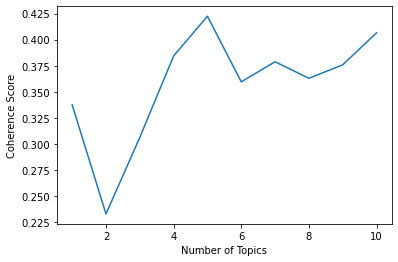

In [12]:
x = range(1,11,1)
plt.plot(x,coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show

In [13]:
for m,cv in zip(x, coherence_values):
    print("Number of topics =", m, " has Coherence value of", round(cv,4))

Number of topics = 1  has Coherence value of 0.3375
Number of topics = 2  has Coherence value of 0.2331
Number of topics = 3  has Coherence value of 0.3064
Number of topics = 4  has Coherence value of 0.3844
Number of topics = 5  has Coherence value of 0.4224
Number of topics = 6  has Coherence value of 0.3596
Number of topics = 7  has Coherence value of 0.3788
Number of topics = 8  has Coherence value of 0.363
Number of topics = 9  has Coherence value of 0.3759
Number of topics = 10  has Coherence value of 0.4065


In [14]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.132915 -0.185023       1        1  25.274022
2      0.386133  0.086346       2        1  25.211656
1     -0.045237 -0.229873       3        1  25.095281
3     -0.207980  0.328550       4        1  24.419041, topic_info=         Term          Freq         Total Category  logprob  loglift
10     flight  14209.000000  14209.000000  Default  30.0000  30.0000
34      thank  10131.000000  10131.000000  Default  29.0000  29.0000
28       time   9086.000000   9086.000000  Default  28.0000  28.0000
173     plane   6352.000000   6352.000000  Default  27.0000  27.0000
11       hour   6072.000000   6072.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
159    toilet    781.123652    781.964248   Topic4  -5.0308   1.4087
751       pie    936.109124    937.178026   Topic4  -4.8498   1.4087
4936  charade   1535.131988   1576.986879   Topic4  -4.3551   1.3829
9     airport   3966.965751   8078.754756   Topic4  -3.4058   0.6986
58      night   1079.257506   1561.109711   Topic4  -4.7075   1.0407

[162 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
137       4  0.999467      airline
9         1  0.300046      airport
9         3  0.208819      airport
9         4  0.491041      airport
1200      1  0.999103  anniversary
...     ...       ...          ...
254       1  0.999424      website
41        4  0.999833         week
46        4  0.999482         work
183       4  0.999898         year
47        4  0.999242    yesterday

[140 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

## Topic modelling with bigrams and trigrams

**1) unigrams:** single word that represents a single concept.<br>
**2) bigrams:** two words that contain a distinct meaning when used together.<br>
**3) trigrams:**  three words that contain a distinct meaning when used together.<br>

So, why are bigrams and trigrams so important? Because machines need to understand that when certain words are used together, they bear a distinct meaning. In order to produce a good topic model, therefore, the model must be able to understand and process words in this manner, the way we humans use the language we are trying to get the machine to understand.

In [15]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_bigrams_trigrams = process_words(data_words)  # processed Text Data!
print (data_bigrams_trigrams[0])

['update', 'passenger', 'coach']


## TF-IDF

In [16]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] 
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [17]:
# Build LDA model
lda_model_grams = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='symmetric',
                                           per_word_topics=True)

In [18]:
print(lda_model_grams.print_topics())
doc_lda = lda_model_grams[corpus]

[(0, '0.075*"time" + 0.054*"plane" + 0.048*"year" + 0.040*"parking" + 0.034*"love" + 0.018*"guy" + 0.016*"website" + 0.015*"work" + 0.015*"car" + 0.012*"perfume"'), (1, '0.138*"flight" + 0.059*"hour" + 0.047*"morning" + 0.032*"week" + 0.030*"bag" + 0.025*"minute" + 0.021*"luggage" + 0.021*"tomorrow" + 0.015*"night" + 0.015*"min"'), (2, '0.071*"airport" + 0.045*"people" + 0.042*"security" + 0.034*"staff" + 0.023*"birthday" + 0.018*"travel" + 0.018*"drop" + 0.015*"number" + 0.014*"delay" + 0.014*"queue"'), (3, '0.092*"thank" + 0.047*"day" + 0.044*"family" + 0.036*"today" + 0.021*"passenger" + 0.021*"home" + 0.020*"service" + 0.019*"baggage" + 0.018*"bus" + 0.018*"holiday"')]


In [19]:
lda_coherence_model = CoherenceModel(model= lda_model_grams, texts = data_bigrams_trigrams, dictionary = id2word,
                                    coherence='c_v')
coherence_lda = lda_coherence_model.get_coherence()

print("Coherence Score:", coherence_lda)

Coherence Score: 0.3080077071293482


In [20]:
def opt_coherence(dictionary, corpus, texts, limit, start=1, step=1):
    
    coherence_values=[]
    model_list = []
    for topics in range(start,limit,step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics = topics, random_state=100,
                                               chunksize=1000, passes = 10, per_word_topics=True, id2word=id2word, alpha ='symmetric')
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=data_bigrams_trigrams, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

model_list, coherence_values = opt_coherence(dictionary = id2word, corpus=corpus, texts =data_bigrams_trigrams, start=1, limit=11,step=1)

<function matplotlib.pyplot.show(close=None, block=None)>

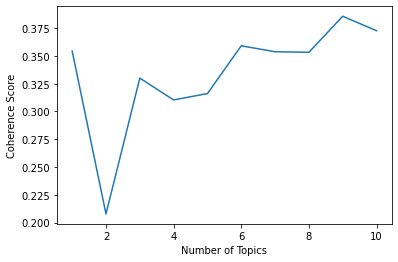

In [21]:
x = range(1,11,1)
plt.plot(x,coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show

As we can see, number of topics = 4, has the higher coherence value, so we will use this one in our model.

In [22]:
for m,cv in zip(x, coherence_values):
    print("Number of topics =", m, " has Coherence value of", round(cv,4))

Number of topics = 1  has Coherence value of 0.3543
Number of topics = 2  has Coherence value of 0.2077
Number of topics = 3  has Coherence value of 0.33
Number of topics = 4  has Coherence value of 0.3104
Number of topics = 5  has Coherence value of 0.3161
Number of topics = 6  has Coherence value of 0.3591
Number of topics = 7  has Coherence value of 0.3538
Number of topics = 8  has Coherence value of 0.3532
Number of topics = 9  has Coherence value of 0.3857
Number of topics = 10  has Coherence value of 0.3726


In [23]:
pyLDAvis.enable_notebook()
vis_grams = pyLDAvis.gensim_models.prepare(lda_model_grams, corpus, id2word, mds="mmds", R=30)
vis_grams

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.235805 -0.312080       1        1  26.480806
1      0.302702  0.233669       2        1  25.257048
0     -0.236299  0.314230       3        1  24.529357
3     -0.302208 -0.235820       4        1  23.732788, topic_info=           Term          Freq         Total Category  logprob  loglift
10       flight  15802.000000  15802.000000  Default  30.0000  30.0000
33        thank   9949.000000   9949.000000  Default  29.0000  29.0000
27         time   8376.000000   8376.000000  Default  28.0000  28.0000
9       airport   8557.000000   8557.000000  Default  27.0000  27.0000
11         hour   6713.000000   6713.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
445        hand    542.931430    543.758415   Topic4  -5.2893   1.4368
5115    charade   1620.315712   1664.016384   Topic4  -4.1959   1.4117
1     passenger   2244.859303   3606.709639   Topic4  -3.8699   0.9642
16      arrival    777.041056   2236.159788   Topic4  -4.9308   0.3813
201         lot    674.883940   1196.590548   Topic4  -5.0718   0.8656

[159 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
132       3  0.999190      airline
9         1  0.999887      airport
1433      1  0.001070  anniversary
1433      2  0.001070  anniversary
1433      3  0.998524  anniversary
...     ...       ...          ...
248       3  0.999680      website
38        2  0.999729         week
43        3  0.999485         work
179       3  0.999902         year
44        2  0.999535    yesterday

[135 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

## Topic distribution across documents

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

In [24]:
def topic_dist(ldamodel,corpus,texts):

    #Init Output
    sent_topics = pd.DataFrame()
    
    #Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse = True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: # dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics = sent_topics.append(pd.Series([int(topic_num+1), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
        
    sent_topics.columns= ["Dominant_Topic", "Percentage_Contribution", "Topic_Keywords"]
    
    ## Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics= pd.concat([sent_topics, contents], axis=1)
    return(sent_topics)

In [25]:
df_sent_topics = topic_dist(ldamodel=lda_model_grams, corpus=corpus, texts = data_bigrams_trigrams)
df_topic_sents_keywords = topic_dist(ldamodel=lda_model_grams, corpus=corpus, texts=data_bigrams_trigrams)

In [26]:
df_topic_distribution = df_sent_topics["Dominant_Topic"].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ["Dominant_Topic", "Num Documents"]
df_topic_distribution.sort_values("Dominant_Topic")

,Dominant_Topic,Num Documents
0,1.0,136442
1,2.0,46642
3,3.0,44165
2,4.0,45939


In [27]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5613,"thank, day, family, today, passenger, home, se...","[update, passenger, coach]"
1,1,1.0,0.8194,"time, plane, year, parking, love, guy, website...","[lad, rally, troop, pal]"
2,2,1.0,0.2500,"time, plane, year, parking, love, guy, website...",[]
3,3,4.0,0.6250,"thank, day, family, today, passenger, home, se...",[service]
4,4,1.0,0.2500,"time, plane, year, parking, love, guy, website...",[]
5,5,4.0,0.7495,"thank, day, family, today, passenger, home, se...","[service, hospitality]"
6,6,2.0,0.5417,"flight, hour, morning, week, bag, minute, lugg...","[hour, flight, problem, airport, turn]"
7,7,1.0,0.2500,"time, plane, year, parking, love, guy, website...",[]
8,8,3.0,0.6250,"airport, people, security, staff, birthday, tr...",[queue]
9,9,1.0,0.2500,"time, plane, year, parking, love, guy, website...",[]


## The most representative sentence for each topic

In [28]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Percentage_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1.0,0.9166,"time, plane, year, parking, love, guy, website, work, car, perfume","[boy, girl, girl, boy, attempt, girl, buying, victim]"
1,2.0,0.9062,"flight, hour, morning, week, bag, minute, luggage, tomorrow, night, min","[story, flight, arrive, dublin, tomorrow, flight, morning]"
2,3.0,0.8929,"airport, people, security, staff, birthday, travel, drop, number, delay, queue","[picture, travel, song, way, song, tweet]"
3,4.0,0.9003,"thank, day, family, today, passenger, home, service, baggage, bus, holiday","[post_box, north, terminal, place, post, letter, thank]"


## Word Clouds of Top N Keywords in Each Topic

pyLDAvis to Wordcloud the topic number change (try to solve but couldn't understand how), so:

- Topic 1 = Topic 1(cloud)
- Topic 2 = Topic 4(cloud)
- Topic 3 = Topic 2(cloud)
- Topic 4 = Topic 3(cloud)

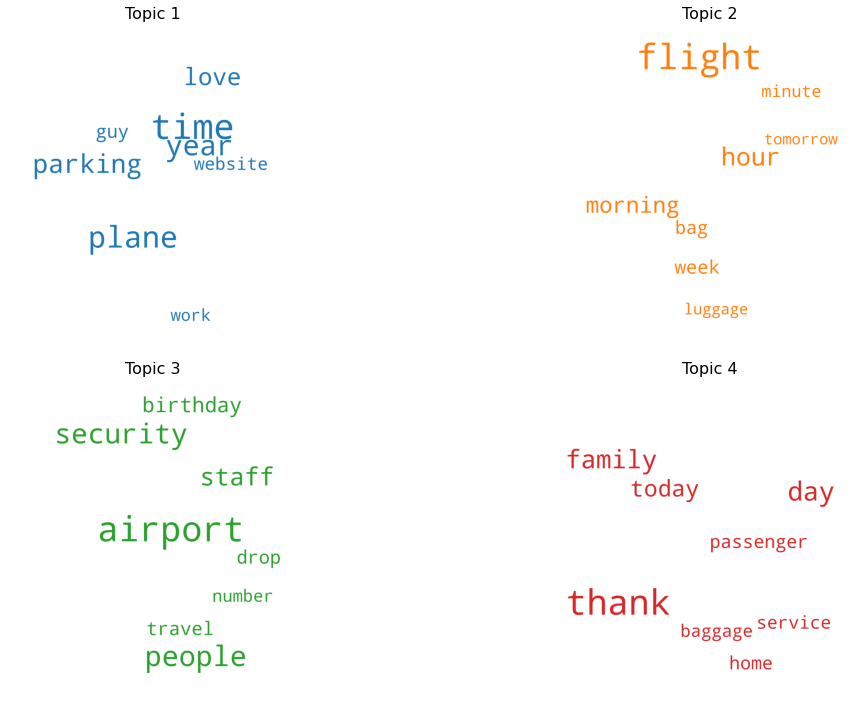

In [29]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2800,
                  max_words=8,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_grams.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()